<a href="https://colab.research.google.com/github/andreavittino/colab_notebooks/blob/main/CatsVsDogs.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Here we consider a small dataset of pictures of cats and dogs (3000 pictures, 2000 will be used for training and 1000 for validation). Our aim will be to classify the images. To this end, we will use CNNs, starting from a very simple model without regularization or data augmentation. Then we will improve on that, first by using data augmentation and then by applying transfer learning (using the VGG16 network). 

Most of what follows is based on Chap. 5 of the book "Deep learning with Python" by F. Chollet 

In [1]:
from google.colab import files

# Data collection
We start by downloading the data and looking at a few pictures from the dataset

In [2]:
 !wget --no-check-certificate \
    https://storage.googleapis.com/mledu-datasets/cats_and_dogs_filtered.zip \
    -O cats_and_dogs_filtered.zip

--2020-10-15 15:10:39--  https://storage.googleapis.com/mledu-datasets/cats_and_dogs_filtered.zip
Resolving storage.googleapis.com (storage.googleapis.com)... 74.125.133.128, 74.125.140.128, 108.177.15.128, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|74.125.133.128|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 68606236 (65M) [application/zip]
Saving to: ‘cats_and_dogs_filtered.zip’

cats_and_dogs_filte 100%[===================>]  65.43M  28.8MB/s    in 2.3s    

2020-10-15 15:10:42 (28.8 MB/s) - ‘cats_and_dogs_filtered.zip’ saved [68606236/68606236]



In [3]:
import os
import zipfile

local_zip = 'cats_and_dogs_filtered.zip'
zip_ref = zipfile.ZipFile(local_zip, 'r')
zip_ref.extractall()
zip_ref.close()

In [4]:
base_dir = 'cats_and_dogs_filtered'
train_dir = os.path.join(base_dir, 'train')
validation_dir = os.path.join(base_dir, 'validation')

# Directory with our training cat pictures
train_cats_dir = os.path.join(train_dir, 'cats')

# Directory with our training dog pictures
train_dogs_dir = os.path.join(train_dir, 'dogs')

# Directory with our validation cat pictures
validation_cats_dir = os.path.join(validation_dir, 'cats')

# Directory with our validation dog pictures
validation_dogs_dir = os.path.join(validation_dir, 'dogs')

In [5]:
print('total training cat images:', len(os.listdir(train_cats_dir)))
print('total training dog images:', len(os.listdir(train_dogs_dir)))
print('total validation cat images:', len(os.listdir(validation_cats_dir)))
print('total validation dog images:', len(os.listdir(validation_dogs_dir)))

total training cat images: 1000
total training dog images: 1000
total validation cat images: 500
total validation dog images: 500


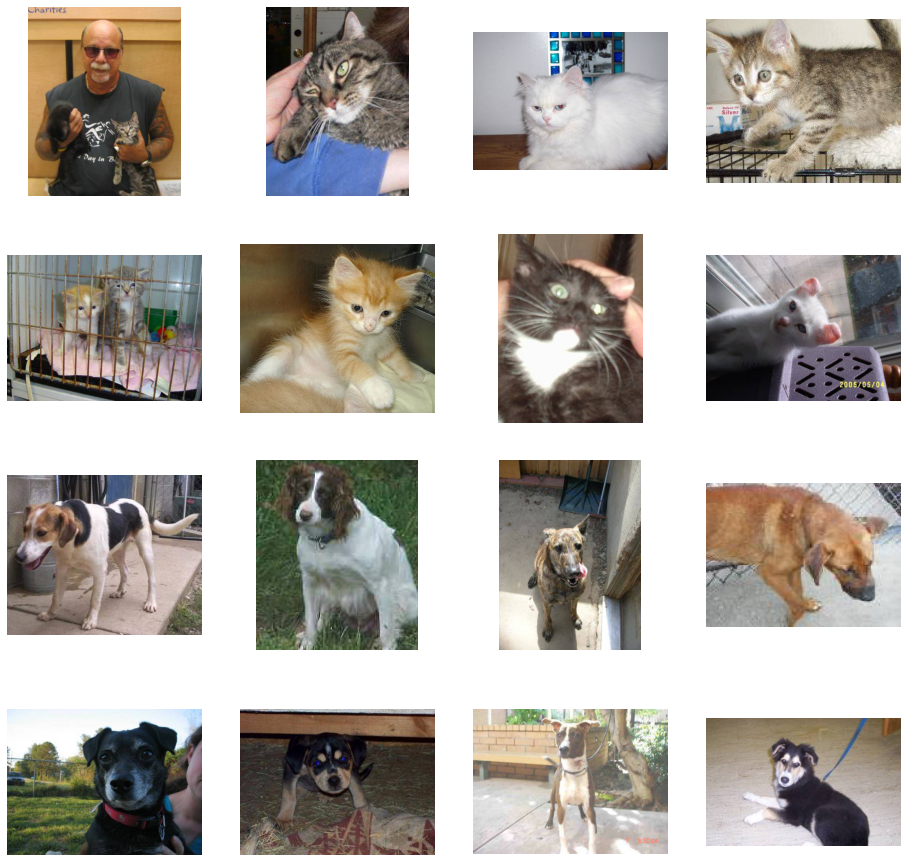

In [6]:
import matplotlib.pyplot as plt
import matplotlib.image as mpimg


train_cat_fnames = os.listdir(train_cats_dir)
train_dog_fnames = os.listdir(train_dogs_dir)

nrows = 4
ncols = 4
pic_index = 0

# Set up matplotlib fig, and size it to fit 4x4 pics
fig = plt.gcf()
fig.set_size_inches(ncols * 4, nrows * 4)

pic_index += 8
next_cat_pix = [os.path.join(train_cats_dir, fname) 
                for fname in train_cat_fnames[pic_index-8:pic_index]]
next_dog_pix = [os.path.join(train_dogs_dir, fname) 
                for fname in train_dog_fnames[pic_index-8:pic_index]]

for i, img_path in enumerate(next_cat_pix+next_dog_pix):
  # Set up subplot; subplot indices start at 1
  sp = plt.subplot(nrows, ncols, i + 1)
  sp.axis('Off') # Don't show axes (or gridlines)

  img = mpimg.imread(img_path)
  plt.imshow(img)

plt.show()

# First try: A simple CNN 
We start with a very simple CNN, built by stacking alternated convolutional and pooling layers.  

In [7]:
# We start by defining the model
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Dense, Flatten

model = Sequential([
                    Conv2D(32,(3,3),input_shape = (150,150,3),activation = 'relu'),
                    MaxPooling2D((2,2)),
                    Conv2D(64, (3,3),activation='relu'),
                    MaxPooling2D((2,2)),
                    Conv2D(128, (3,3), activation='relu'),
                    MaxPooling2D((2,2)),
                    Conv2D(128, (3,3), activation='relu'),
                    MaxPooling2D((2,2)),
                    Flatten(),
                    Dense(512,activation='relu'),
                    Dense(1,activation='sigmoid')
])
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 148, 148, 32)      896       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 74, 74, 32)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 72, 72, 64)        18496     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 36, 36, 64)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 34, 34, 128)       73856     
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 17, 17, 128)       0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 15, 15, 128)       1

In [8]:
# We compile the model
model.compile(optimizer = 'adam',loss = 'binary_crossentropy', metrics=['accuracy'])

In [9]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator
# we need to rescale the data, to have them in the [0,1] range
train_datagen = ImageDataGenerator(rescale=1./255.)
validation_datagen = ImageDataGenerator(rescale=1./255.)
train_generator = train_datagen.flow_from_directory(train_dir, 
                                                    target_size = (150,150),
                                                    batch_size=20,
                                                    class_mode = 'binary')
validation_generator = validation_datagen.flow_from_directory(validation_dir,
                                                              target_size=(150,150),
                                                              batch_size=20,
                                                              class_mode = 'binary')

Found 2000 images belonging to 2 classes.
Found 1000 images belonging to 2 classes.


In [10]:
# We fit the model
history = model.fit_generator(train_generator, steps_per_epoch = 100 ,epochs = 30, validation_data = validation_generator, validation_steps =50)

Instructions for updating:
Please use Model.fit, which supports generators.
Epoch 1/30
100/100 [==============================] - 11s 106ms/step - loss: 0.6932 - accuracy: 0.5380 - val_loss: 0.6891 - val_accuracy: 0.5000
Epoch 2/30
100/100 [==============================] - 11s 105ms/step - loss: 0.6909 - accuracy: 0.5325 - val_loss: 0.6773 - val_accuracy: 0.6030
Epoch 3/30
100/100 [==============================] - 10s 105ms/step - loss: 0.6792 - accuracy: 0.5475 - val_loss: 0.6962 - val_accuracy: 0.5230
Epoch 4/30
100/100 [==============================] - 11s 105ms/step - loss: 0.6662 - accuracy: 0.6000 - val_loss: 0.6355 - val_accuracy: 0.6420
Epoch 5/30
100/100 [==============================] - 10s 105ms/step - loss: 0.6376 - accuracy: 0.6300 - val_loss: 0.6251 - val_accuracy: 0.6680
Epoch 6/30
100/100 [==============================] - 10s 103ms/step - loss: 0.5814 - accuracy: 0.6805 - val_loss: 0.5981 - val_accuracy: 0.6890
Epoch 7/30
100/100 [==============================] - 

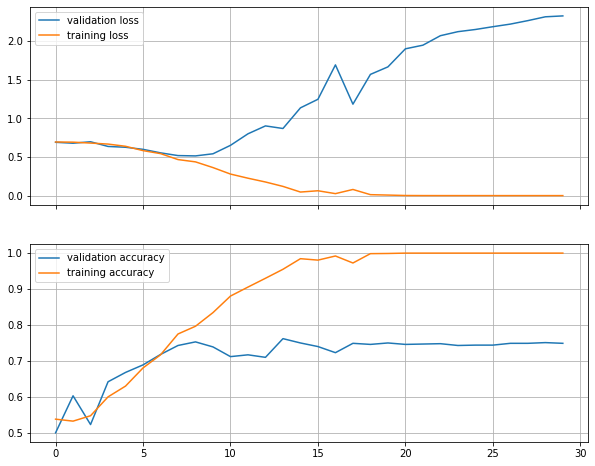

In [11]:
# We plot the training and validation loss and accuracy
import matplotlib.pyplot as plt
fig, ax = plt.subplots(nrows=2,ncols=1,figsize=(10,8),sharex=True)
ax[0].plot(history.history['val_loss'], label = 'validation loss')
ax[0].plot(history.history['loss'], label = 'training loss')
ax[0].legend()
ax[1].plot(history.history['val_accuracy'],label = 'validation accuracy')
ax[1].plot(history.history['accuracy'],label = 'training accuracy')
ax[1].legend()
ax[0].grid()
ax[1].grid()

# Second try: Adding data augmentation

As we saw, our simple model overfits the data. This might be due to the very limited number of pictures we are using for training. We try to mitigate this by augmenting the data by performing a series of random transformation on the training set. 

In [12]:
train_datagen = ImageDataGenerator(rescale=1./255.,
                                   rotation_range=40,
                                   width_shift_range=0.2,
                                   height_shift_range=0.2,
                                   shear_range=0.2,
                                   zoom_range = 0.2,
                                   horizontal_flip=True)
validation_datagen = ImageDataGenerator(rescale=1./255.)
train_generator = train_datagen.flow_from_directory(train_dir, 
                                                    target_size = (150,150),
                                                    batch_size=20,
                                                    class_mode = 'binary')
validation_generator = validation_datagen.flow_from_directory(validation_dir,
                                                              target_size=(150,150),
                                                              batch_size=20,
                                                              class_mode = 'binary')

Found 2000 images belonging to 2 classes.
Found 1000 images belonging to 2 classes.


In [13]:
# we fit the model
history = model.fit_generator(train_generator, steps_per_epoch = 100 ,epochs = 80, validation_data = validation_generator, validation_steps =50)

Epoch 1/80
100/100 [==============================] - 19s 194ms/step - loss: 0.8443 - accuracy: 0.5475 - val_loss: 0.6650 - val_accuracy: 0.5310
Epoch 2/80
100/100 [==============================] - 19s 195ms/step - loss: 0.6725 - accuracy: 0.5920 - val_loss: 0.6438 - val_accuracy: 0.6180
Epoch 3/80
100/100 [==============================] - 20s 196ms/step - loss: 0.6677 - accuracy: 0.5935 - val_loss: 0.6336 - val_accuracy: 0.6680
Epoch 4/80
100/100 [==============================] - 19s 193ms/step - loss: 0.6439 - accuracy: 0.6260 - val_loss: 0.5850 - val_accuracy: 0.6960
Epoch 5/80
100/100 [==============================] - 19s 192ms/step - loss: 0.6110 - accuracy: 0.6590 - val_loss: 0.5291 - val_accuracy: 0.7550
Epoch 6/80
100/100 [==============================] - 19s 193ms/step - loss: 0.6163 - accuracy: 0.6545 - val_loss: 0.5487 - val_accuracy: 0.7310
Epoch 7/80
100/100 [==============================] - 19s 192ms/step - loss: 0.6090 - accuracy: 0.6785 - val_loss: 0.5383 - val_ac

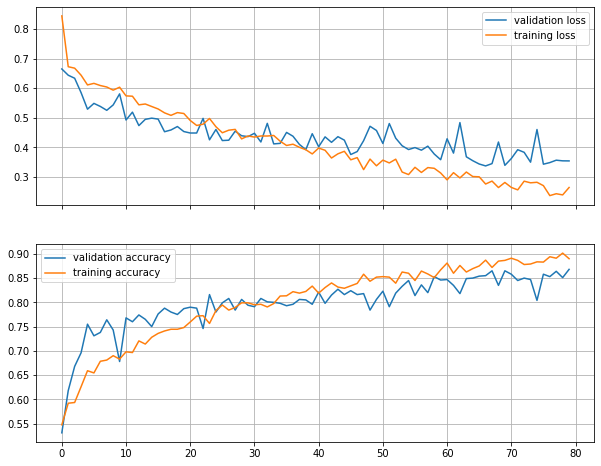

In [14]:
# We plot the training and validation loss and accuracy
import matplotlib.pyplot as plt
fig, ax = plt.subplots(nrows=2,ncols=1,figsize=(10,8),sharex=True)
ax[0].plot(history.history['val_loss'], label = 'validation loss')
ax[0].plot(history.history['loss'], label = 'training loss')
ax[0].legend()
ax[1].plot(history.history['val_accuracy'],label = 'validation accuracy')
ax[1].plot(history.history['accuracy'],label = 'training accuracy')
ax[1].legend()
ax[0].grid()
ax[1].grid()

# Third try: Using transfer learning (without data augmentation)

We use here a network (the VGG16 network) pretrained on the ImageNet dataset. We will perform feature extraction, i.e. we will use the representations learned by the VGG16 network on the ImageNet dataset to extract features from the dataset we are studying here. 

In our first use of transfer learning we will adopt the simplest possible approach, which consists in running the convolutional base over the dataset and using this data as an input to a stand-alone densely connected classifier.

In [15]:
from tensorflow.keras.applications import VGG16

In [16]:
conv_base = VGG16(include_top = False, weights='imagenet',input_shape = (150,150,3))

58892288/58889256 [==============================] - 1s 0us/step


In [17]:
conv_base.summary()

Model: "vgg16"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 150, 150, 3)]     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 150, 150, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 150, 150, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 75, 75, 64)        0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 75, 75, 128)       73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 75, 75, 128)       147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 37, 37, 128)       0     

In [18]:
import numpy as np
datagen = ImageDataGenerator(rescale=1./255.)
batch_size = 20
def extract_features(directory,num_samples):
  features = np.zeros(shape=(num_samples,4,4,512))
  labels = np.zeros(shape=(num_samples))
  generator = datagen.flow_from_directory(directory,
                                          target_size=(150,150),
                                          batch_size=batch_size,
                                          class_mode = 'binary')
  i = 0
  for inputs_batch, labels_batch in generator:
    features_batch = conv_base.predict(inputs_batch)
    features[i*batch_size : (i+1)*batch_size] = features_batch
    labels[i*batch_size : (i+1)*batch_size] = labels_batch
    i+=1
    if i*batch_size >= num_samples:
      break 
  return features, labels

In [19]:
train_features, train_labels = extract_features(train_dir, 2000)
validation_features, validation_labels = extract_features(validation_dir,1000)
train_features = np.reshape(train_features,(2000,4*4*512))
validation_features = np.reshape(validation_features,(1000,4*4*512))

Found 2000 images belonging to 2 classes.
Found 1000 images belonging to 2 classes.


In [20]:
from tensorflow.keras.layers import Dropout
model = Sequential([
                    Dense(256,activation = 'relu', input_dim = 4*4*512),
                    Dropout(0.3),
                    Dense(1,activation='sigmoid')    
])
model.compile(optimizer='adam',loss='binary_crossentropy',metrics=['accuracy'])
history = model.fit(train_features,train_labels,epochs=30,batch_size=20,validation_data=(validation_features,validation_labels))

Epoch 1/30
100/100 [==============================] - 1s 5ms/step - loss: 0.4070 - accuracy: 0.8225 - val_loss: 0.2565 - val_accuracy: 0.8920
Epoch 2/30
100/100 [==============================] - 0s 4ms/step - loss: 0.2110 - accuracy: 0.9160 - val_loss: 0.2986 - val_accuracy: 0.8610
Epoch 3/30
100/100 [==============================] - 0s 4ms/step - loss: 0.1606 - accuracy: 0.9350 - val_loss: 0.2745 - val_accuracy: 0.8840
Epoch 4/30
100/100 [==============================] - 0s 4ms/step - loss: 0.1057 - accuracy: 0.9585 - val_loss: 0.2742 - val_accuracy: 0.8850
Epoch 5/30
100/100 [==============================] - 0s 4ms/step - loss: 0.0834 - accuracy: 0.9670 - val_loss: 0.2899 - val_accuracy: 0.8930
Epoch 6/30
100/100 [==============================] - 0s 4ms/step - loss: 0.0672 - accuracy: 0.9730 - val_loss: 0.4574 - val_accuracy: 0.8530
Epoch 7/30
100/100 [==============================] - 0s 4ms/step - loss: 0.0500 - accuracy: 0.9830 - val_loss: 0.3238 - val_accuracy: 0.8790
Epoch 

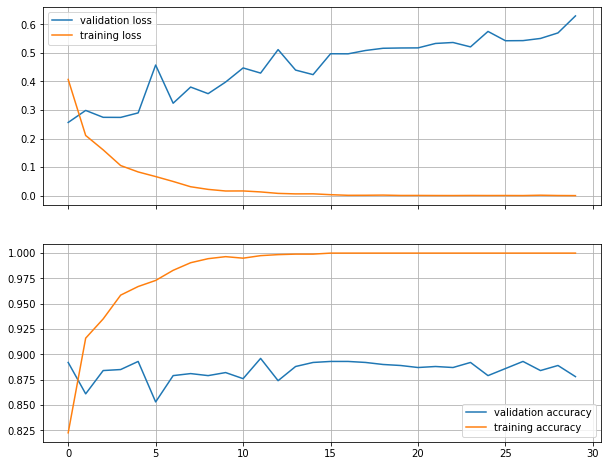

In [21]:
fig, ax = plt.subplots(nrows=2,ncols=1,figsize=(10,8),sharex=True)
ax[0].plot(history.history['val_loss'], label = 'validation loss')
ax[0].plot(history.history['loss'], label = 'training loss')
ax[0].legend()
ax[1].plot(history.history['val_accuracy'],label = 'validation accuracy')
ax[1].plot(history.history['accuracy'],label = 'training accuracy')
ax[1].legend()
ax[0].grid()
ax[1].grid()

# Fourth try: Using transfer learning (with data augmentation)

Here we refine our approach by using data augmentation. This requires all the data to pass through the full model (i.e.. the convolutional base from VGG16 + the densely connected classifier). 

In [22]:
model = Sequential([conv_base,
                    Flatten(),
                    Dense(256,activation='relu'),
                    Dense(1,activation='sigmoid')
])
model.layers[0].trainable=False

In [23]:
train_datagen = ImageDataGenerator(rescale=1./255.,
                                   rotation_range=40,
                                   width_shift_range=0.2,
                                   height_shift_range=0.2,
                                   shear_range=0.2,
                                   zoom_range = 0.2,
                                   horizontal_flip=True)
validation_datagen = ImageDataGenerator(rescale=1./255.)
train_generator = train_datagen.flow_from_directory(train_dir, 
                                                    target_size = (150,150),
                                                    batch_size=20,
                                                    class_mode = 'binary')
validation_generator = validation_datagen.flow_from_directory(validation_dir,
                                                              target_size=(150,150),
                                                              batch_size=20,
                                                              class_mode = 'binary')

Found 2000 images belonging to 2 classes.
Found 1000 images belonging to 2 classes.


In [24]:
model.compile(optimizer = 'adam',loss = 'binary_crossentropy', metrics=['accuracy'])
history = model.fit_generator(train_generator, steps_per_epoch = 100 ,epochs = 30, validation_data = validation_generator, validation_steps =50)

Epoch 1/30
100/100 [==============================] - 24s 243ms/step - loss: 0.6694 - accuracy: 0.7030 - val_loss: 0.3523 - val_accuracy: 0.8320
Epoch 2/30
100/100 [==============================] - 24s 240ms/step - loss: 0.3792 - accuracy: 0.8240 - val_loss: 0.2925 - val_accuracy: 0.8780
Epoch 3/30
100/100 [==============================] - 24s 236ms/step - loss: 0.3430 - accuracy: 0.8480 - val_loss: 0.4027 - val_accuracy: 0.8230
Epoch 4/30
100/100 [==============================] - 23s 230ms/step - loss: 0.3573 - accuracy: 0.8435 - val_loss: 0.2826 - val_accuracy: 0.8810
Epoch 5/30
100/100 [==============================] - 23s 230ms/step - loss: 0.3596 - accuracy: 0.8355 - val_loss: 0.2651 - val_accuracy: 0.8940
Epoch 6/30
100/100 [==============================] - 23s 233ms/step - loss: 0.3158 - accuracy: 0.8560 - val_loss: 0.3078 - val_accuracy: 0.8690
Epoch 7/30
100/100 [==============================] - 23s 233ms/step - loss: 0.3379 - accuracy: 0.8510 - val_loss: 0.2609 - val_ac

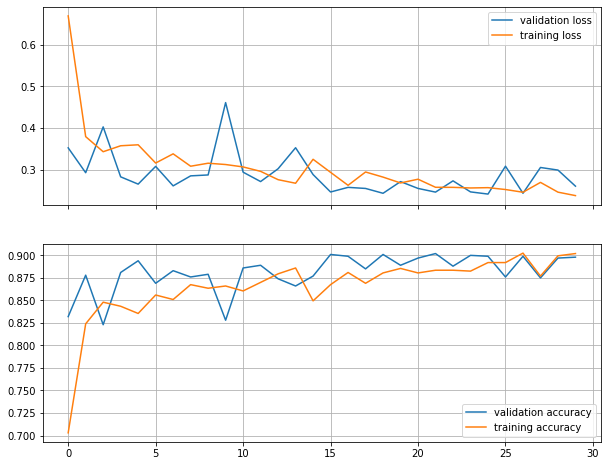

In [25]:
fig, ax = plt.subplots(nrows=2,ncols=1,figsize=(10,8),sharex=True)
ax[0].plot(history.history['val_loss'], label = 'validation loss')
ax[0].plot(history.history['loss'], label = 'training loss')
ax[0].legend()
ax[1].plot(history.history['val_accuracy'],label = 'validation accuracy')
ax[1].plot(history.history['accuracy'],label = 'training accuracy')
ax[1].legend()
ax[0].grid()
ax[1].grid()